# Feature Engineering
# 신용거래 이상탐지 데이터 프로젝트

In [245]:
import pandas as pd
import numpy as np
import seaborn as sns

In [246]:
fraud = pd.read_csv('~/data/fraud.csv')

In [247]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   merchant               491134 non-null  object 
 3   category               491134 non-null  object 
 4   amt                    491134 non-null  float64
 5   first                  491134 non-null  object 
 6   last                   491134 non-null  object 
 7   gender                 491134 non-null  object 
 8   street                 491134 non-null  object 
 9   city                   491134 non-null  object 
 10  state                  491134 non-null  object 
 11  zip                    491134 non-null  int64  
 12  lat                    491134 non-null  float64
 13  long                   491134 non-null  float64
 14  city_pop               491134 non-nu

In [248]:
fraud.describe()

cc_num            amt            zip            lat  \
count  4.911340e+05  491134.000000  491134.000000  491134.000000   
mean   3.706013e+17      69.050120   50770.532384      37.931230   
std    1.260229e+18     160.322867   26854.947965       5.341193   
min    5.038744e+11       1.000000    1843.000000      24.655700   
25%    2.131124e+14       8.960000   28405.000000      33.746700   
50%    3.531130e+15      42.170000   49628.000000      38.507200   
75%    4.653879e+15      80.330000   75048.000000      41.520500   
max    4.956829e+18   25086.940000   99323.000000      48.887800   

                long      city_pop     unix_time      merch_lat  \
count  491134.000000  4.911340e+05  4.911340e+05  491134.000000   
mean      -90.495619  1.213922e+05  1.358730e+09      37.930272   
std        12.990732  3.725751e+05  1.819402e+07       5.372986   
min      -122.345600  4.600000e+01  1.325376e+09      23.655789   
25%       -97.235100  1.228000e+03  1.343087e+09      33.781388   
50%       -87.591700  5.760000e+03  1.357257e+09      38.545124   
75%       -80.731000  5.083500e+04  1.374626e+09      41.624294   
max       -69.965600  2.906700e+06  1.388534e+09      49.887523   

          merch_long       is_fraud  
count  491134.000000  491134.000000  
mean      -90.495411       0.002533  
std        13.004100       0.050264  
min      -123.345106       0.000000  
25%       -96.984814       0.000000  
50%       -87.573441       0.000000  
75%       -80.685567       0.000000  
max       -68.965624       1.000000

- 통계 요약만으로는 판단이 어려워 하나씩 뜯어봐야겠다

# Step1. 데이터 정제

### 1.1 결측치 및 중복 데이터

In [249]:
# 결측치 없음
fraud.isnull().mean()

trans_date_trans_time    0.0
cc_num                   0.0
merchant                 0.0
category                 0.0
amt                      0.0
first                    0.0
last                     0.0
gender                   0.0
street                   0.0
city                     0.0
state                    0.0
zip                      0.0
lat                      0.0
long                     0.0
city_pop                 0.0
job                      0.0
dob                      0.0
trans_num                0.0
unix_time                0.0
merch_lat                0.0
merch_long               0.0
is_fraud                 0.0
dtype: float64

In [250]:
# 중복 데이터 없음
fraud[fraud.duplicated()]

Empty DataFrame
Columns: [trans_date_trans_time, cc_num, merchant, category, amt, first, last, gender, street, city, state, zip, lat, long, city_pop, job, dob, trans_num, unix_time, merch_lat, merch_long, is_fraud]
Index: []

[0 rows x 22 columns]

In [251]:
# 사기 거래 여부 예측에 불필요한 요소 삭제
# 특정인 구분할 수 있는 cc_num 외에 고객식별에 이용되는 object형 삭제
fraud_ = fraud.drop(columns=['first', 'last', 'job', 'street', 'city', 'state'])
# gender, category는 원핫인코딩

In [252]:
fraud['category'].value_counts()

shopping_pos      48345
gas_transport     46029
home              43340
grocery_pos       42722
kids_pets         40295
shopping_net      39179
food_dining       35980
personal_care     35513
entertainment     33619
misc_pos          32411
health_fitness    31415
misc_net          25179
grocery_net       24486
travel            12621
Name: category, dtype: int64

### 1.2 사기 거래 특징 찾기

In [253]:
fraud_[fraud_['is_fraud'] == 0].groupby('cc_num').size().reset_index(name='count').sort_values(by='count')

cc_num  count
56   3511378610369890   3617
85   4005676619255478   3628
34    213157767990030   3629
41    371226440126102   3631
54   3500969075198072   3631
..                ...    ...
92   4642255475285942   4374
24     36722699017270   4376
21     30270432095985   4377
104  6011367958204270   4380
76   3583635130604947   4380

[124 rows x 2 columns]

In [254]:
fraud_counts = fraud_[fraud_['is_fraud'] == 1].groupby('cc_num').size().reset_index(name='count').sort_values(by='count', ascending=False)
fraud_counts

cc_num  count
110  6538441737335434     18
53   2720433095629877     16
31    213112402583773     16
69   3556613125071656     16
58   3518669219150142     16
..                ...    ...
67   3551217896304745      3
108  6011893664860915      2
101  6011109736646996      2
75   3576431665303017      2
57   3518234918950662      2

[122 rows x 2 columns]

In [255]:
f_merchant = fraud_[fraud_['is_fraud'] == 1].groupby('merchant').size().reset_index(name='count').sort_values(by='count').reset_index()

In [256]:
n_merchant = fraud_[fraud_['is_fraud'] == 0].groupby('merchant').size().reset_index(name='count').sort_values(by='count').reset_index()

In [257]:
n_merchant.sort_values(by='merchant').head(3)

index                  merchant  count
294      0       fraud_Abbott-Rogahn    688
327      1      fraud_Abbott-Steuber    709
308      2  fraud_Abernathy and Sons    697

In [258]:
f_merchant.sort_values(by='merchant').head(3)

index                  merchant  count
0        0       fraud_Abbott-Rogahn      1
224      1      fraud_Abbott-Steuber      2
229      2  fraud_Abernathy and Sons      2

In [259]:
merged_df = f_merchant.merge(n_merchant['merchant'].drop_duplicates(), how='inner')
merged_df.sort_values(by='count').tail(3)

index                              merchant  count
493    267  fraud_Langworth, Boehm and Gulgowski      9
494    224                     fraud_Kilback LLC      9
496    313        fraud_Moen, Reinger and Murphy     11

merchant, customer 특징만으로는 사기거래 잡을 수 없음
- merge 결과 : 사기거래 일어난 모든 merchant에는 정상거래 빈도가 훨씬 많이 있음
- 소수의 사기거래가 어떤 양상으로 나타나는 지 알아봐야 함..

In [261]:
fraud.groupby('is_fraud')['cc_num'].agg('count').reset_index()

is_fraud  cc_num
0         0  489890
1         1    1244

In [262]:
fraud_count = fraud_[fraud_['is_fraud'] == 1]['is_fraud'].count()
total_count = fraud_.shape[0]

# 사기거래 비율
fraud_ratio = fraud_count / total_count * 100

result_df = pd.DataFrame({
    'Count': [fraud_count, total_count],
    'Ratio': [f'{fraud_ratio:.2f}%', f'{100 - fraud_ratio:.2f}%']
}, index=['Fraud', 'Non-Fraud'])

print(result_df.reset_index())


       index   Count   Ratio
0      Fraud    1244   0.25%
1  Non-Fraud  491134  99.75%


In [263]:
fraud_[fraud_['cc_num']==3511378610369890].sort_values(by='is_fraud', ascending=False).head(12) #동일인 거래 3628건 중 11건 사기거래

trans_date_trans_time            cc_num  \
240563   2019-12-29 03:04:22  3511378610369890   
240295   2019-12-28 22:08:50  3511378610369890   
240450   2019-12-28 23:58:34  3511378610369890   
239115   2019-12-28 03:31:06  3511378610369890   
240570   2019-12-29 03:19:24  3511378610369890   
241991   2019-12-29 22:00:23  3511378610369890   
242194   2019-12-29 23:58:16  3511378610369890   
239049   2019-12-28 01:42:22  3511378610369890   
239021   2019-12-28 00:48:36  3511378610369890   
238996   2019-12-28 00:03:54  3511378610369890   
240306   2019-12-28 22:15:36  3511378610369890   
329960   2020-06-02 19:52:49  3511378610369890   

                                   merchant        category      amt gender  \
240563    fraud_Herman, Treutel and Dickens        misc_net   813.21      M   
240295               fraud_Volkman-Predovic    shopping_net   945.40      M   
240450  fraud_Effertz, Welch and Schowalter   entertainment   524.53      M   
239115     fraud_Stehr, Jewess and Schimmel        misc_net   893.18      M   
240570    fraud_Bernier, Volkman and Hoeger        misc_net   818.45      M   
241991   fraud_Turner, Ruecker and Parisian        misc_pos     8.71      M   
242194                     fraud_Mohr-Bayer    shopping_net   954.97      M   
239049        fraud_Lockman, West and Runte     grocery_pos   333.29      M   
239021                  fraud_Stracke-Lemke     grocery_pos   319.51      M   
238996                   fraud_Bauch-Raynor     grocery_pos   310.79      M   
240306               fraud_Rippin-VonRueden  health_fitness    19.17      M   
329960                    fraud_Haley Group        misc_pos  1390.66      M   

          zip      lat     long  city_pop         dob  \
240563  35811  34.7789 -86.5438    190178  1973-04-01   
240295  35811  34.7789 -86.5438    190178  1973-04-01   
240450  35811  34.7789 -86.5438    190178  1973-04-01   
239115  35811  34.7789 -86.5438    190178  1973-04-01   
240570  35811  34.7789 -86.5438    190178  1973-04-01   
241991  35811  34.7789 -86.5438    190178  1973-04-01   
242194  35811  34.7789 -86.5438    190178  1973-04-01   
239049  35811  34.7789 -86.5438    190178  1973-04-01   
239021  35811  34.7789 -86.5438    190178  1973-04-01   
238996  35811  34.7789 -86.5438    190178  1973-04-01   
240306  35811  34.7789 -86.5438    190178  1973-04-01   
329960  35811  34.7789 -86.5438    190178  1973-04-01   

                               trans_num   unix_time  merch_lat  merch_long  \
240563  c885fae4e40042e2a181222116fa91f8  1356750262  35.209741  -86.420910   
240295  1d1ef8dcb69abb3312790449afec19a3  1356732530  34.370872  -87.277540   
240450  e3834d3e25db6e1c34cbddcc469f5214  1356739114  34.226652  -85.827488   
239115  e1824cb2521630cfc2f5a4454bae00e5  1356665466  35.497907  -85.842681   
240570  dc8060a8f46338d3b9cfbfdc0e3ca252  1356751164  35.023483  -87.071080   
241991  4830d257d7146428c099441e14329bb5  1356818423  35.667711  -87.385162   
242194  447b47e8c46dabaf131cb66dc90b3f9d  1356825496  35.193223  -85.843108   
239049  ce173ce4583a1c3d57095bb82e0ec72e  1356658942  35.343043  -85.763886   
239021  cf9c54a361bfb844bdd579e63b7fce40  1356655716  35.746925  -86.799034   
238996  1f213905b7c35e1926aa450b18305860  1356653034  34.181241  -87.168502   
240306  d47c226810e57a6a730f4acdb529edfb  1356732936  34.019900  -85.995718   
329960  01ff18b2bd2b4ceb122e494efd35c1f7  1370202769  34.824416  -87.423629   

        is_fraud  
240563         1  
240295         1  
240450         1  
239115         1  
240570         1  
241991         1  
242194         1  
239049         1  
239021         1  
238996         1  
240306         1  
329960         0

In [264]:
fraud.groupby('cc_num')['is_fraud'].value_counts().reset_index(name='count')

cc_num  is_fraud  count
0           503874407318         0   3646
1           503874407318         1      9
2           567868110212         0   3641
3           567868110212         1      3
4           571365235126         0   4364
..                   ...       ...    ...
241  4861310130652566408         1      9
242  4906628655840914250         0   3644
243  4906628655840914250         1     11
244  4956828990005111019         0   3647
245  4956828990005111019         1     10

[246 rows x 3 columns]

- 사기거래와 정상거래 여부가 같은 고객 아래 섞여 있음
- 사용자 평소 패턴과 다른 움직임, 즉 이상패턴을 감지할 수 있도록 데이터 정제 필요

### 1.3 날짜 데이터 정제

In [265]:
fraud_['trans_date_trans_time'] = pd.to_datetime(fraud_['trans_date_trans_time'])

In [266]:
fraud_.groupby('cc_num')['trans_date_trans_time'].describe(datetime_is_numeric=True)

count                          mean                 min  \
cc_num                                                                        
503874407318         3655 2020-01-22 03:17:46.577838592 2019-01-01 04:34:51   
567868110212         3644 2020-01-19 13:10:48.858671872 2019-01-01 17:03:45   
571365235126         4374 2020-01-15 04:32:57.515775232 2019-01-01 01:02:53   
581686439828         3653 2020-01-17 20:56:44.544210176 2019-01-01 03:00:10   
630423337322         4362 2020-01-19 13:12:03.490371584 2019-01-01 00:00:44   
...                   ...                           ...                 ...   
4792627764422477317  4357 2020-01-15 16:19:21.995868672 2019-01-01 13:31:53   
4797297220948468262  3653 2020-01-25 05:28:12.613194752 2019-01-01 04:25:51   
4861310130652566408  3643 2020-01-24 07:07:07.966511360 2019-01-01 10:26:03   
4906628655840914250  3655 2020-01-19 11:51:33.331874048 2019-01-01 16:39:07   
4956828990005111019  3657 2020-01-16 06:09:10.786983680 2019-01-01 00:12:34   

                                              25%                     50%  \
cc_num                                                                      
503874407318        2019-07-21 12:30:04.500000000 2020-01-02 22:45:16.000   
567868110212        2019-07-17 13:01:20.249999872 2019-12-30 17:48:26.500   
571365235126        2019-07-22 16:33:43.000000000 2019-12-27 01:45:19.000   
581686439828        2019-07-22 17:57:29.000000000 2019-12-28 23:18:01.000   
630423337322        2019-07-19 16:58:08.500000000 2019-12-29 23:22:36.500   
...                                           ...                     ...   
4792627764422477317 2019-07-16 03:40:51.000000000 2019-12-31 15:43:28.000   
4797297220948468262 2019-07-29 11:30:59.000000000 2020-01-16 01:38:36.000   
4861310130652566408 2019-07-27 09:41:19.000000000 2020-01-04 21:22:17.000   
4906628655840914250 2019-07-27 17:03:59.000000000 2019-12-30 11:57:22.000   
4956828990005111019 2019-07-19 14:08:26.000000000 2019-12-24 17:14:05.000   

                                              75%                 max  
cc_num                                                                 
503874407318        2020-07-27 21:24:52.000000000 2020-12-31 23:22:02  
567868110212        2020-07-22 08:47:45.500000000 2020-12-31 22:53:17  
571365235126        2020-07-13 19:17:42.249999872 2020-12-31 21:15:09  
581686439828        2020-07-21 22:25:32.000000000 2020-12-31 21:58:23  
630423337322        2020-07-27 17:10:11.249999872 2020-12-31 23:17:42  
...                                           ...                 ...  
4792627764422477317 2020-07-18 18:44:45.000000000 2020-12-31 15:56:25  
4797297220948468262 2020-07-26 01:06:08.000000000 2020-12-31 19:13:17  
4861310130652566408 2020-07-27 04:53:23.000000000 2020-12-31 20:16:50  
4906628655840914250 2020-07-16 12:40:58.500000000 2020-12-31 22:00:07  
4956828990005111019 2020-07-22 23:18:21.000000000 2020-12-31 18:11:45  

[124 rows x 7 columns]

In [267]:
fraud_['shopping_time'] = fraud_['trans_date_trans_time'].dt.time
fraud_['shopping_time_h'] = fraud_['trans_date_trans_time'].dt.hour

In [268]:
fraud_counts = fraud_.groupby(['cc_num', 'shopping_time_h', 'is_fraud']).size().reset_index(name='count')
filtered_fraud = fraud_counts[(fraud_counts['count'] < 50) & (fraud_counts['is_fraud'] == 0)]
filtered_fraud.head(30).sort_values(by='is_fraud')

cc_num  shopping_time_h  is_fraud  count
1492  2264937662466770                3         0     47
2799  4653879239169997                9         0     48
2791  4653879239169997                3         0     47
2223  3576021480694169               10         0     46
2153  3567697931646329                2         0     48
2069  3556613125071656                4         0     46
2061  3556613125071656                0         0     46
2801  4653879239169997               11         0     49
1923  3541160328600277               10         0     48
1728  3518669219150142                1         0     48
1533  2283743876903625               11         0     48
1532  2283743876903625               10         0     46
1523  2283743876903625                3         0     46
1497  2264937662466770                6         0     46
1494  2264937662466770                4         0     44
1738  3518669219150142                8         0     48
3225  6011693194885790                7         0     44

### 1.4 구매 금액

In [269]:
fraud_['amt'].describe()

count    491134.000000
mean         69.050120
std         160.322867
min           1.000000
25%           8.960000
50%          42.170000
75%          80.330000
max       25086.940000
Name: amt, dtype: float64

<AxesSubplot:ylabel='amt'>

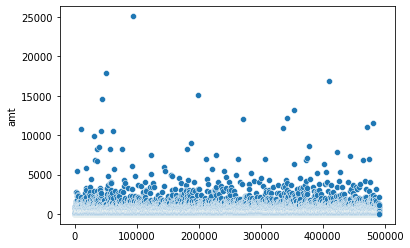

In [270]:
sns.scatterplot(x=fraud_.index, y=fraud_['amt'])

<AxesSubplot:>

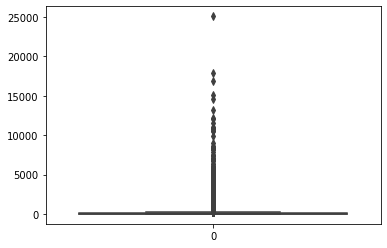

In [271]:
sns.boxplot(data=fraud_['amt'], boxprops=dict(facecolor="skyblue"))

In [272]:
fraud_[fraud_['is_fraud']==1]['amt'].max()
#.sort_values(by='amt')

1371.81

In [273]:
fraud_[fraud_['is_fraud']==1].sort_values(by='amt')

trans_date_trans_time               cc_num  \
69246    2019-05-11 02:11:21     3533742182628021   
312034   2020-05-07 03:39:43  4536996888716062123   
352986   2020-07-03 22:19:41     3589255887819806   
131834   2019-08-05 00:22:03      213157767990030   
70054    2019-05-12 06:31:47     3533742182628021   
...                      ...                  ...   
311971   2020-05-06 23:11:57  4536996888716062123   
75667    2019-05-20 23:09:59     2720433095629877   
316777   2020-05-14 23:53:49        4745996322265   
7933     2019-01-18 23:20:16     4586810168620942   
135833   2019-08-10 22:10:23     3500969075198072   

                                      merchant       category      amt gender  \
69246                     fraud_Corwin-Collins  gas_transport     6.38      M   
312034     fraud_Greenholt, Jacobi and Gleason  gas_transport     6.44      M   
352986     fraud_Nienow, Ankunding and Collier       misc_pos     6.67      M   
131834                       fraud_Block Group       misc_pos     6.69      F   
70054                        fraud_Schmitt Inc  gas_transport     6.70      M   
...                                        ...            ...      ...    ...   
311971                        fraud_Fisher Inc   shopping_net  1253.93      M   
75667   fraud_Stanton, Jakubowski and Baumbach   shopping_net  1262.19      M   
316777           fraud_Kuhic, Bins and Pfeffer   shopping_net  1276.77      F   
7933                       fraud_Pouros-Conroy   shopping_pos  1334.07      F   
135833                        fraud_Metz-Boehm   shopping_pos  1371.81      M   

          zip      lat      long  city_pop         dob  \
69246   29455  32.8357  -79.8217     20478  1997-06-04   
312034  87533  35.9866 -106.0654     18408  1972-07-18   
352986  21750  39.6991  -78.1762      3766  1984-02-14   
131834  82901  41.6060 -109.2300     27971  1984-08-01   
70054   29455  32.8357  -79.8217     20478  1997-06-04   
...       ...      ...       ...       ...         ...   
311971  87533  35.9866 -106.0654     18408  1972-07-18   
75667    4287  44.0575  -69.9656      3224  1997-08-22   
316777  46346  41.4802  -86.6919      1423  1998-10-07   
7933    29438  32.5486  -80.3070      2408  1997-07-05   
135833  99033  47.2271 -117.0819       895  1999-05-31   

                               trans_num   unix_time  merch_lat  merch_long  \
69246   3727cf537ff8592fdd46d5beb02a24f3  1336702281  32.191323  -80.357341   
312034  86efe90ef8b3342ced83cf2823406471  1367897983  36.618873 -105.141180   
352986  3ff79c3fc560882aa125a5e7ebb474df  1372889981  40.042611  -77.734092   
131834  7b430cbaa0f2d32dc6c6fb0e24e88abd  1344126123  41.873253 -109.671622   
70054   4c93fb9df4c3de881377cb0762d7419f  1336804307  33.484412  -80.001776   
...                                  ...         ...        ...         ...   
311971  2cba079a307eca2f8d34d92ddadb6783  1367881917  35.190482 -105.604155   
75667   dffe9a4375a6e74c2b9c4502bd09bcce  1337555399  43.879003  -70.439097   
316777  42b5333784b7efcb3216cc606be17508  1368575629  42.174728  -86.972444   
7933    f0c086495d403024ce6d30f715713319  1326928816  31.615611  -79.702908   
135833  20cf5453224328229e06ae7b4df10302  1344636623  47.065996 -116.262297   

        is_fraud shopping_time  shopping_time_h  
69246          1      02:11:21                2  
312034         1      03:39:43                3  
352986         1      22:19:41               22  
131834         1      00:22:03                0  
70054          1      06:31:47                6  
...          ...           ...              ...  
311971         1      23:11:57               23  
75667          1      23:09:59               23  
316777         1      23:53:49               23  
7933           1      23:20:16               23  
135833         1      22:10:23               22  

[1244 rows x 18 columns]

In [274]:
fraud_.groupby('cc_num')['amt'].mean()

cc_num
503874407318           60.253406
567868110212           83.442558
571365235126           59.392974
581686439828           58.578675
630423337322           56.078113
                         ...    
4792627764422477317    84.135134
4797297220948468262    56.313583
4861310130652566408    85.805306
4906628655840914250    54.243453
4956828990005111019    59.858059
Name: amt, Length: 124, dtype: float64

## 1.2 feature Engineering

In [275]:
fraud_.nunique()

trans_date_trans_time    488474
cc_num                      124
merchant                    693
category                     14
amt                       36446
gender                        2
zip                         124
lat                         124
long                        124
city_pop                    122
dob                         123
trans_num                491134
unix_time                488477
merch_lat                484503
merch_long               487445
is_fraud                      2
shopping_time             84608
shopping_time_h              24
dtype: int64

### 1️⃣ 거래 시간대
- 출근시간, 점심시간, 퇴근/저녁식사 등 시간대 별로 나누어 라벨링

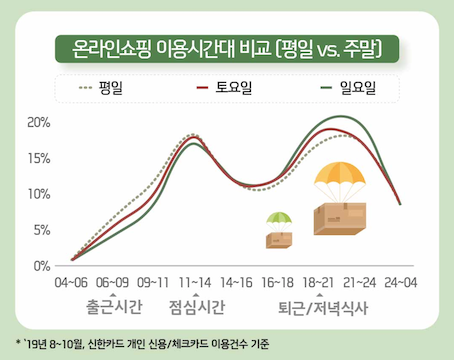
                🔼 위 시간대 참고하였음

In [276]:
fraud['shopping_hour'] = pd.to_datetime(fraud['trans_date_trans_time']).dt.hour

In [277]:
# 시간대 나누어서 라벨링
bins = [-np.inf, 4, 6, 9, 11, 14, 16, 18, 21, 24]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]

fraud['time'] = pd.cut(fraud['shopping_hour'], bins=bins, labels=labels)

In [278]:
fraud.sort_values(by='time')

trans_date_trans_time            cc_num  \
0        2019-01-01 00:00:44      630423337322   
86783    2019-06-06 01:01:19   377026671291680   
86782    2019-06-06 00:51:41  4836998673805450   
86781    2019-06-06 00:41:46  4586810168620942   
86780    2019-06-06 00:38:12  6011652924285713   
...                      ...               ...   
292974   2020-04-05 23:08:24   372520049757633   
292973   2020-04-05 23:08:20   213157767990030   
292972   2020-04-05 23:08:13  5540636818935089   
292982   2020-04-05 23:20:43      630451534402   
491133   2020-12-31 23:59:34  4170689372027579   

                                   merchant        category     amt  \
0           fraud_Heller, Gutmann and Zieme     grocery_pos  107.23   
86783                       fraud_Berge LLC   gas_transport   58.09   
86782                   fraud_Gutmann-Upton        misc_pos   13.43   
86781                     fraud_Huels-Nolan   gas_transport   56.10   
86780                  fraud_Murray-Smitham     grocery_pos  125.54   
...                                     ...             ...     ...   
292974                fraud_Reilly and Sons  health_fitness   52.72   
292973                   fraud_Lynch-Wisozk            home   35.16   
292972                   fraud_Johns-Hoeger   entertainment   33.83   
292982  fraud_Effertz, Welch and Schowalter   entertainment   27.11   
491133                    fraud_Dare-Marvin   entertainment   38.13   

            first      last gender                        street  \
0       Stephanie      Gill      F  43039 Riley Greens Suite 393   
86783      Jackie     Davis      F     1898 Parker Fork Apt. 057   
86782       Susan     Hardy      F               516 Brown Parks   
86781    Michelle   Gregory      F            6983 Carrillo Isle   
86780     Kathryn     Smith      F  19838 Tonya Prairie Apt. 947   
...           ...       ...    ...                           ...   
292974       Lori   Ramirez      F          4293 Ramirez Squares   
292973       Tara  Campbell      F    05050 Rogers Well Apt. 439   
292972    Kenneth    Foster      M         329 Michael Extension   
292982     Rachel   Daniels      F     561 Little Plain Apt. 738   
491133     Samuel      Frey      M      830 Myers Plaza Apt. 384   

                 city  ... city_pop                                job  \
0              Orient  ...      149  Special educational needs teacher   
86783         Redford  ...      241                 Investment analyst   
86782      Manistique  ...     6469                Trade mark attorney   
86781   Edisto Island  ...     2408             Sales professional, IT   
86780     Rocky Mount  ...     1847                      Tax inspector   
...               ...  ...      ...                                ...   
292974         Ranier  ...      136                  Ceramics designer   
292973   Rock Springs  ...    27971                    Music therapist   
292972       Lawrence  ...    76383                       Geoscientist   
292982        Wetmore  ...      765                       Immunologist   
491133         Edmond  ...   116001                        Media buyer   

               dob                         trans_num   unix_time  merch_lat  \
0       1978-06-21  1f76529f8574734946361c461b024d99  1325376044  49.159047   
86783   1974-10-27  8afda9afda1ad275381d65088be7ab9c  1338944479  38.298025   
86782   1979-04-12  a6355baa8722ed0988937e6e70def74c  1338943901  46.088002   
86781   1997-07-05  4073047522302cd4edde05e89ee13453  1338943306  32.272297   
86780   1988-10-26  1ba6fcc32f77d148d170325802b68216  1338943092  37.889018   
...            ...                               ...         ...        ...   
292974  2000-02-20  fe3ccee8d90c1b744f49aebaa2ae241f  1365203304  49.386004   
292973  1984-08-01  3a34743770bb33c59ad12b1b8de5ea16  1365203300  41.394424   
292972  1985-04-04  d51f316cbbf98dbcc69ccf02caa415aa  1365203293  43.130733   
292982  1972-06-12  61a6f8af61de2d00405e9a2bd86cc31e  136

### 2️⃣ 나이

In [279]:
fraud['age'] = fraud['dob'].apply(lambda x : 2023 - int(x[:4]))

In [280]:
fraud_['age'] = fraud.dob.apply(lambda x: 2023 - int(x[:4]))
fraud_['age'].describe()

count    491134.000000
mean         38.615769
std           9.297579
min          19.000000
25%          31.000000
50%          39.000000
75%          47.000000
max          53.000000
Name: age, dtype: float64

### 3️⃣ 거리차

### 거리 차이 구하기
- 구매자와 판매자 사이 거리를 구한 후 사기 거래 탐지에 활용하기
- 예를 들어, 한국에서 거래 후 30분 후 미국에서 거래하는 경우처럼 지리 기반으로 이상탐지 가능

In [281]:
d_lat = fraud['lat'] - fraud['merch_lat']
d_long = fraud['long'] - fraud['merch_long']

fraud['distance(km)'] = np.sqrt(d_lat**2 + d_long**2) * 6371

In [282]:
# 불필요한 행 제거
fraud.drop(columns=['trans_date_trans_time', 'dob', 'shopping_hour', 'unix_time'], inplace=True)

In [ ]:
fraud.drop(columns=['street', 'first', 'last', 'city', 'zip', 'city_pop', 'job'], inplace=True)

In [286]:
fraud.drop(columns=['lat', 'long', 'merch_lat', 'merch_long', 'merchant'], inplace=True)

### 4️⃣ 원핫인코딩

In [290]:
gender = pd.get_dummies(fraud.gender, prefix='gender')
category = pd.get_dummies(fraud.category, prefix='cat')
df_new = pd.concat([fraud, category, gender], axis=1).drop(columns=['category', 'gender'])
df_new.head()

cc_num     amt state                         trans_num  \
0         630423337322  107.23    WA  1f76529f8574734946361c461b024d99   
1  4956828990005111019   44.71    NJ  09eff9c806365e2a6be12c1bbab3d70e   
2      180048185037117   46.28    NJ  19e23c6a300c774354417befe4f31f8c   
3      374930071163758   64.09    MI  6f363661ba6b55889e488dd178f2a0af   
4     2712209726293386   25.58    LA  1654da2abfb9e79a5f99167fc9779558   

   is_fraud time  age  distance(km)  cat_entertainment  cat_food_dining  ...  \
0         0    0   45   1734.887295                  0                0  ...   
1         0    0   43   5494.475778                  0                0  ...   
2         0    0   49   3962.935369                  0                0  ...   
3         0    0   52   1524.753531                  0                0  ...   
4         0    0   46   4655.620295                  0                0  ...   

   cat_home  cat_kids_pets  cat_misc_net  cat_misc_pos  cat_personal_care  \
0         0              0             0             0                  0   
1         0              0             0             0                  0   
2         0              0             0             0                  0   
3         0              0             0             0                  0   
4         0              0             0             1                  0   

   cat_shopping_net  cat_shopping_pos  cat_travel  gender_F  gender_M  
0                 0                 0           0         1         0  
1                 0                 0           0         0         1  
2                 0                 0           0         1         0  
3                 0                 0           0         0         1  
4                 0                 0           0         1         0  

[5 rows x 24 columns]

### 5️⃣ Scaler 

In [318]:
from sklearn.preprocessing import RobustScaler, StandardScaler

num_cols = ['amt', 'distance(km)', 'age']
# remove outliers
robust_scaler = RobustScaler()
df_new[num_cols] = robust_scaler.fit_transform(df_new[num_cols])

# standardization
std_scaler = StandardScaler()
df_new[num_cols] = std_scaler.fit_transform(df_new[num_cols])

In [324]:
df_new.drop(columns=['state'])

cc_num       amt                         trans_num  \
0              630423337322  0.238144  1f76529f8574734946361c461b024d99   
1       4956828990005111019 -0.151820  09eff9c806365e2a6be12c1bbab3d70e   
2           180048185037117 -0.142027  19e23c6a300c774354417befe4f31f8c   
3           374930071163758 -0.030938  6f363661ba6b55889e488dd178f2a0af   
4          2712209726293386 -0.271141  1654da2abfb9e79a5f99167fc9779558   
...                     ...       ...                               ...   
491129     6011109736646996  0.406741  fc860b0d1f89b0b068c9c8db27b6bcc5   
491130      213112402583773 -0.271703  0f0c38fe781b317f733b845c0d6ba448   
491131     3556613125071656  0.266898  2090647dac2c89a1d86c514c427f5b91   
491132     6011724471098086  0.111212  6c5b7c8add471975aa0fec023b2e8408   
491133     4170689372027579 -0.192862  1765bb45b3aa3224b4cdcb6e7a96cee3   

        is_fraud time       age  distance(km)  cat_entertainment  \
0              0    0  0.686656     -1.733642                  0   
1              0    0  0.471546      0.339622                  0   
2              0    0  1.116876     -0.504962                  0   
3              0    0  1.439541     -1.849523                  0   
4              0    0  0.794211     -0.122974                  0   
...          ...  ...       ...           ...                ...   
491129         0    8  0.148881      0.790645                  0   
491130         0    8  0.041326      1.587226                  0   
491131         0    8 -1.571999      0.722988                  0   
491132         0    8  0.363991      0.595606                  0   
491133         0    8 -0.926669     -0.225686                  1   

        cat_food_dining  cat_gas_transport  ...  cat_home  cat_kids_pets  \
0                     0                  0  ...         0              0   
1                     0                  0  ...         0              0   
2                     0                  0  ...         0              0   
3                     0                  0  ...         0              0   
4                     0                  0  ...         0              0   
...                 ...                ...  ...       ...            ...   
491129                0                  0  ...         1              0   
491130                0                  0  ...         0              0   
491131                0                  0  ...         0              1   
491132                0                  0  ...         0              1   
491133                0                  0  ...         0              0   

        cat_misc_net  cat_misc_pos  cat_personal_care  cat_shopping_net  \
0                  0             0                  0                 0   
1                  0             0                  0                 0   
2                  0             0                  0                 0   
3                  0             0                  0                 0   
4                  0             1                  0                 0   
...              ...           ...                ...               ...   
491129             0             0                  0                 0   
491130             0             0                  0                 0   
491131             0             0                  0                 0   
491132             0             0                  0                 0   
491133             0             0                  0                 0   

        cat_shopping_pos  cat_travel  gender_F  gender_M  
0                      0           0         1         0  
1                      0           0         0         1  
2                      0           0         1         0  
3                      0           0         0         1  
4                      0           0         1         0  
...                  ...         ...       ...       ...  
491129                 0           0         1         0  
491130           

# Step2. 데이터 심화

In [291]:
fraud = pd.read_csv('~/data/fraud.csv')
f_ = fraud[fraud['is_fraud'] == 1] # 사기거래
n_ = fraud[fraud['is_fraud'] == 0] # 정상거래

## 2.1 데이터의 위도/경도 정보 활용
- lat: latitude of the customer, long: longitude of customer, merch_lat: merchant lattitude, merch_long: merchant longitude

In [17]:
!pip install geopy

In [22]:
from geopy.geocoders import Nominatim

def geocoding_reverse(lat_lng_str): 
    geolocoder = Nominatim(user_agent = 'America', timeout=None)
    address = geolocoder.reverse(lat_lng_str)

    return address

address = geocoding_reverse('48.8878, -118.2105')
print(address)

Stevens County, Washington, United States


- 위도, 경도 정보를 활용하여 위치 출력 및 표시 가능

In [36]:
from geopy.geocoders import Nominatim

def geocoding_reverse(lat_lng_str): 
    geolocoder = Nominatim(user_agent = 'America', timeout=None)
    address = geolocoder.reverse(lat_lng_str)

    return address


for i, (lat, long) in enumerate(zip(fraud_geo_['lat'], fraud_geo_['long'])):
    address = geocoding_reverse(f"{lat}, {long}")
    print(address)


Stevens County, Washington, United States
32, Trotters Lane, Elizabeth, Union County, New Jersey, 07208, United States
Absolute Waterproofing & Renovation, 143, Crescent Avenue, Plainfield, Union County, New Jersey, 07060, United States
West Service Drive, Romulus, Wayne County, Michigan, 48174, United States
4692, Whitehaven Street, Southdowns, Hyacinth Terrace, Baton Rouge, East Baton Rouge Parish, Louisiana, 70808, United States
418, Oak Street, Bellmore, Town of Hempstead, Nassau County, New York, 11710, United States
Highway 49 South, Lakeland, Florence, Rankin County, Mississippi, 39218, United States
Jewell County, Kansas, United States
Grand County, Utah, United States
18520, Main Street, Conway, Mount Vernon, Skagit County, Washington, 98273, United States


In [300]:
import folium

fraud_df = f_[f_['is_fraud'] == 1]

map_center = [fraud_df["lat"].mean(), fraud_df["long"].mean()]
fraud_map = folium.Map(location=map_center, 
                       zoom_start=5, 
                       control_scale=True,  # 지도 우측 하단에 축척바 표시
                         tiles='OpenStreetMap')

for index, row in fraud_df.iterrows():
    location = [row['lat'], row['long']]
    popup_text = f"Transaction ID: {row['trans_num']}\nAmount: {row['amt']}\nMerchant: {row['merchant']}"
    
    # 구매자와 판매자를 다른 색상
    folium.Marker(location=location, popup=popup_text, icon=folium.Icon(color='blue')).add_to(fraud_map)

    merch_location = [row['merch_lat'], row['merch_long']]
    merch_popup_text = f"Merchant: {row['merchant']}"
    folium.Marker(location=merch_location, popup=merch_popup_text, icon=folium.Icon(color='red')).add_to(fraud_map)

map_title_html = '''
                <h3 align="center" style="font-size:20px"><b>Fraudulent Transactions Map</b></h3>
                '''

fraud_map.get_root().html.add_child(folium.Element(map_title_html))

fraud_map


- 가까워보인다 그래서 거리로 다시 계산..

### 거리와 시간 관계 구하기
- 구매자와 판매자 사이 거리를 구한 후 사기 거래 탐지에 활용하기
- 예를 들어, 한국에서 거래 후 30분 후 미국에서 거래하는 경우처럼 지리 기반으로 이상탐지 가능
- 가능한 시간차이가 아닌 경우에 이상패턴으로 학습시킬 수 있음

In [ ]:
n_.drop(columns=['trans_date_trans_time', 'dob', 'unix_time', 'street', 'first', 'last', 'city', 'zip', 'city_pop', 'job'], inplace=True)

In [ ]:
d_lat = n_['lat'] - n_['merch_lat']
d_long = n_['long'] - n_['merch_long']

n_.loc[:, 'distance(km)'] = np.sqrt(d_lat**2 + d_long**2) * 6371

In [303]:
d_lat = f_['lat'] - f_['merch_lat']
d_long = f_['long'] - f_['merch_long']

f_['distance(km)'] = np.sqrt(d_lat**2 + d_long**2) * 6371

/tmp/ipykernel_65/2482047080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_['distance(km)'] = np.sqrt(d_lat**2 + d_long**2) * 6371


In [309]:
f_['distance(km)']

4794      3188.088483
4816      5798.745813
4979      6065.496458
5073      6864.677450
5124      8119.549659
             ...     
477832    6982.265105
477847    3297.328081
479296    5784.364118
479305    4681.991863
479341    5873.873352
Name: distance(km), Length: 1244, dtype: float64

In [310]:
n_['distance(km)']

0         1734.887295
1         5494.475778
2         3962.935369
3         1524.753531
4         4655.620295
             ...     
491129    6312.345861
491130    7756.840607
491131    6189.659593
491132    5958.668466
491133    4469.364754
Name: distance(km), Length: 489890, dtype: float64

In [313]:
fraud.nunique()

trans_date_trans_time    488474
cc_num                      124
merchant                    693
category                     14
amt                       36446
first                        92
last                        102
gender                        2
street                      124
city                        121
state                        44
zip                         124
lat                         124
long                        124
city_pop                    122
job                         110
dob                         123
trans_num                491134
unix_time                488477
merch_lat                484503
merch_long               487445
is_fraud                      2
distance(km)             491134
dtype: int64

## 2.2 통계적 관점
### 2.2.1 카이검정

In [317]:
from scipy.stats import chi2_contingency

categorical_vars = ['category', 'state', 'gender', 'is_fraud']

for var in categorical_vars:
    if var != 'is_fraud':
        # 관측도수 테이블 생성
        observed_table = pd.crosstab(fraud[var], fraud['is_fraud'])

        # 카이제곱 검정 수행
        chi2, p, _, _ = chi2_contingency(observed_table)

        # Cramér's V 계산
        n = np.sum(observed_table)
        min_dim = min(observed_table.shape) - 1
        v = np.sqrt(chi2 / (n * min_dim))

        # 결과 출력
        print(f"\n{var} vs is_fraud:")
        print(f"Chi-Square Value: {chi2}")
        print(f"P-value: {p}")
        print(f"Cramér's V: {v}")



category vs is_fraud:
Chi-Square Value: 482.7732904614264
P-value: 6.649403021052898e-95
Cramér's V: is_fraud
0    0.031392
1    0.622962
dtype: float64

state vs is_fraud:
Chi-Square Value: 63.88830023657893
P-value: 0.02093076404811439
Cramér's V: is_fraud
0    0.011420
1    0.226621
dtype: float64

gender vs is_fraud:
Chi-Square Value: 7.7739650245716785
P-value: 0.005300457599276578
Cramér's V: is_fraud
0    0.003984
1    0.079052
dtype: float64


- 카테고리는 사기 여부에 강한 영향을 미치며, 상관 관계가 높다.
- 주(State)는 중간 정도의 상관 관계를 보이며, 통계적으로 유의미한 영향이 있다.
- 성별(Gender)은 약간의 상관 관계를 보이며, 통계적으로 유의미한 영향이 있다.

### 2.2.2 상관관계

In [325]:
df_corr = df_new.corr()
df_corr.style.background_gradient()

<AxesSubplot:>

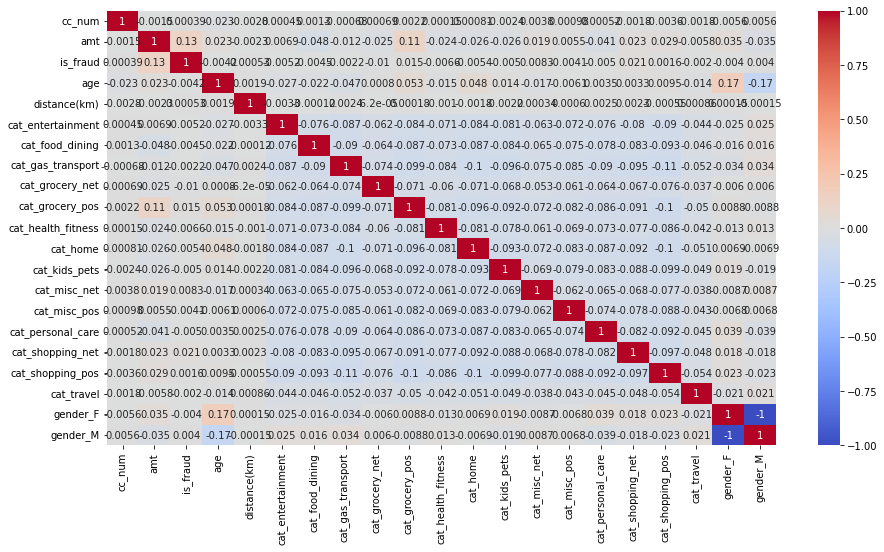

In [326]:
plt.figure(figsize=(15,8))
sns.heatmap(df_corr, annot=True, vmax=1, vmin=-1, cmap="coolwarm")

- 상관관계가 높은 변수들이 있으면 다중공산성 문제를 일으킬 수 있다.
- 분석 결과 모델에 영향을 줄 만한 상관관계 없어 보임

In [1]:
# sns.pairplot(fraud, hue="is_fraud")

# 회고 및 인사이트

1. 새롭게 배운 점
- 데이터 전처리 중요성: 대용량 데이터셋에서 데이터 전처리는 모델링 전에 가장 중요한 단계 중 하나이다. 데이터의 품질을 높이고 모델에 적합한 형태로 가공하는 작업은 모델의 성능에 직접적인 영향을 미친다!

- 지리적 데이터 다루기: Folium 라이브러리를 사용하여 지리적 데이터를 지도에 시각화하는 방법을 학습했다. 지리 정보 활용하여 데이터 탐색하고 이해하는 데에 유용하다.

- SettingWithCopyWarning 이슈 해결(경고성 이슈): Pandas에서 데이터프레임 조작 시 'SettingWithCopyWarning'에 대한 경고를 피하는 방법을 배웠습니다. .loc을 적절히 활용하여 원본 데이터를 수정하는 방식으로 이를 해결했습니다.

2. 어려웠던 점:
- 통계 검정 결과 해석: 통계 검정 결과와 Cramér's V 값을 바탕으로 변수 간의 관계를 정확하게 해석하는 데에 어려움을 겪었습니다. 통계적 개념에 대한 추가 학습이 필요함을 느꼈습니다.

- 데이터 정제 흐름: 데이터를 정제하고 가공하는 흐름을 최적화하는 데에 어려움이 있었습니다. 특히 데이터프레임 조작과 통계 검정, 시각화를 조화롭게 사용하는 것이 필요하다고 느꼈습니다.   

- 데이터 전처리 최적화: 데이터 전처리 작업을 더 효율적으로 수행하기 위해 Pandas의 다양한 함수 및 메서드에 대한 숙지를 강화하고 코드를 최적화할 계획입니다.





3. 정리:   

데이터 전처리와 탐색적 데이터 분석은 모델링 전에 품질 좋은 결과를 얻기 위해 필수적인 과정입니다. 이번 경험을 통해 데이터에 대한 이해를 깊이 갖게 되었고, 모델링 단계에서 더 나은 성과를 이끌어내기 위해 노력할 것입니다. 향후 다양한 프로젝트에서 더 나은 결과물을 도출하고자 합니다.